In [66]:
!python --version

Python 3.11.7


In [67]:
"""
%%capture

# The environment we will be working with
%pip install CityLearn==2.1.2

# For participant interactions (buttons)
%pip install ipywidgets

# To generate static figures
%pip install matplotlib
%pip install seaborn

# Provide standard RL algorithms
%pip install stable-baselines3

# Enable gym compatibility with later stable-baselines3 versions
%pip install shimmy

# Results submission
%pip install requests
%pip install beautifulsoup4
"""

'\n%%capture\n\n# The environment we will be working with\n%pip install CityLearn==2.1.2\n\n# For participant interactions (buttons)\n%pip install ipywidgets\n\n# To generate static figures\n%pip install matplotlib\n%pip install seaborn\n\n# Provide standard RL algorithms\n%pip install stable-baselines3\n\n# Enable gym compatibility with later stable-baselines3 versions\n%pip install shimmy\n\n# Results submission\n%pip install requests\n%pip install beautifulsoup4\n'

In [68]:
import sys, subprocess
print("Python:", sys.executable)
print("Pip:   ", subprocess.run(["which","pip"], capture_output=True, text=True).stdout)

# System operations
import os

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import import_ipynb

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch as th

# CityLearn
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction, SolarPenaltyReward

# Baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.monitor import Monitor


# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

Python: /hkfs/home/haicore/iai/cj9272/citylearn_env/bin/python
Pip:    /software/all/jupyter/ai/2025-05-23/bin/pip



In [69]:
def keep_only_electrical_storage(schema: dict) -> dict: # Set actions to just electical storage
    # Top-level actions
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')

    # Per-building overrides, if present
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema

ROOT_DIRECTORY = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'

dataset = DataSet()
schema = dataset.get_schema('citylearn_challenge_2023_phase_3_1')
schema['root_directory'] = ROOT_DIRECTORY
schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
# Set reward function
schema['reward_function'] = { # CostReward Function
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
# Set pricing file
price_file = 'pricing_germany_2023_june_to_august.csv'  # Pricing CSV
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file


# Building
root_directory = ROOT_DIRECTORY
building_name = 'Building_1'
# Weather data
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
# Pricing data (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
# Carbon Intensity data
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
# building data
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)


bld = building_data.copy()
wth = weather_data.copy()
prc = pricing_data.copy()
car = carbon_intensity_data.copy()

print(pricing_data.head(n=30))
#print(building_data.columns.tolist())

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


    electricity_pricing  electricity_pricing_predicted_1  \
0               0.08415                          0.08415   
1               0.07430                          0.07430   
2               0.07010                          0.07010   
3               0.06672                          0.06672   
4               0.06770                          0.06770   
5               0.08045                          0.08045   
6               0.09704                          0.09704   
7               0.10823                          0.10823   
8               0.09907                          0.09907   
9               0.08730                          0.08730   
10              0.06819                          0.06819   
11              0.05992                          0.05992   
12              0.03886                          0.03886   
13              0.00935                          0.00935   
14              0.00301                          0.00301   
15              0.01335                 

In [70]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

#### Environment
I wrap the DataFrames in a Gym Environment
following the same pattern as the tutorial’s Tabular QL wrapper,
but here I implement a custom `gym.Env` that emits a vector of normalized
features and accepts a *discrete* charge/discharge action.


In [71]:
from citylearn.reward_function import ComfortReward, CostReward

class CityLearnDQNEnv(gym.Env):
    """
    Custom DQN environment over tabular CityLearn data.
    Adaptation A: filter out observation columns that are missing in the loaded CSVs
    to avoid KeyError (e.g. missing *_predicted_* columns).

    Updated: Supports both CityLearn reward classes (with `.calculate`) and a simple
    custom reward callable (with `__call__(obs, action_frac)`).
    """

    def __init__(self,
                 building_df: pd.DataFrame,
                 pricing_df:  pd.DataFrame,
                 weather_df:  pd.DataFrame,
                 carbon_df:   pd.DataFrame,
                 n_bins:      int = 5):
        super().__init__()
        # Raw data (reset index for integer-based access)
        self.bld = building_df.reset_index(drop=True)
        self.prc = pricing_df.reset_index(drop=True)
        self.wth = weather_df.reset_index(drop=True)
        self.car = carbon_df.reset_index(drop=True)
        self.T   = len(self.bld)  # episode length

        self.n_bins = int(n_bins)
        self.action_space = spaces.Discrete(self.n_bins)

        # ---- Dynamic observation column filtering (Adaptation A) ----
        raw_obs_cols = [
            # building_df
            'month','hour','day_type','daylight_savings_status',
            'indoor_dry_bulb_temperature','average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity','non_shiftable_load','dhw_demand',
            'cooling_demand','heating_demand','solar_generation','occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point','hvac_mode',
            # weather_df (actual)
            'outdoor_dry_bulb_temperature','outdoor_relative_humidity',
            'diffuse_solar_irradiance','direct_solar_irradiance',
            # weather_df (predicted – may be missing)
            'outdoor_dry_bulb_temperature_predicted_1',
            'outdoor_dry_bulb_temperature_predicted_2',
            'outdoor_dry_bulb_temperature_predicted_3',
            'outdoor_relative_humidity_predicted_1',
            'outdoor_relative_humidity_predicted_2',
            'outdoor_relative_humidity_predicted_3',
            'diffuse_solar_irradiance_predicted_1',
            'diffuse_solar_irradiance_predicted_2',
            'diffuse_solar_irradiance_predicted_3',
            'direct_solar_irradiance_predicted_1',
            'direct_solar_irradiance_predicted_2',
            'direct_solar_irradiance_predicted_3',
            # carbon & pricing
            'carbon_intensity',
            'electricity_pricing',
            'electricity_pricing_predicted_1',
            'electricity_pricing_predicted_2',
            'electricity_pricing_predicted_3'
        ]

        available_cols = (
            set(self.bld.columns)
            | set(self.wth.columns)
            | set(self.car.columns)
            | set(self.prc.columns)
        )
        self.obs_cols = [c for c in raw_obs_cols if c in available_cols]
        missing = [c for c in raw_obs_cols if c not in available_cols]
        if missing:
            print("Dropping missing observation columns:", missing)

        self.obs_amount = len(self.obs_cols)
        self.bound = 5.0
        low  = -np.ones(self.obs_amount, dtype=np.float32) * self.bound
        high =  np.ones(self.obs_amount, dtype=np.float32) * self.bound
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # --- Stats (only over columns that actually exist) ---
        parts = []
        parts.append(self.bld[[c for c in self.obs_cols if c in self.bld.columns]])
        parts.append(self.wth[[c for c in self.obs_cols if c in self.wth.columns]])
        if 'carbon_intensity' in self.obs_cols and 'carbon_intensity' in self.car.columns:
            parts.append(self.car[['carbon_intensity']])
        if 'electricity_pricing' in self.obs_cols and 'electricity_pricing' in self.prc.columns:
            parts.append(self.prc[['electricity_pricing']])

        all_obs_df = pd.concat(parts, axis=1)
        all_obs_df = all_obs_df.loc[:, ~all_obs_df.columns.duplicated()]
        all_obs_df = all_obs_df.reindex(columns=[c for c in self.obs_cols if c in all_obs_df.columns])
        self.obs_mean = all_obs_df.mean().reindex(self.obs_cols, fill_value=0).values.astype(np.float32)
        self.obs_std  = all_obs_df.std().replace(0, 1).reindex(self.obs_cols, fill_value=1).values.astype(np.float32)

        # Simple battery
        self.capacity = 1.0
        self.soc = 0.5

        self.reward_fn = CostReward(env_metadata=schema)
        # self.reward_fn = ComfortReward(env_metadata=schema, band=2.0, lower_exponent=2, higher_exponent=2)

        # Flag interface type
        self._uses_citylearn_interface = hasattr(self.reward_fn, 'calculate')

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.t = 0
        self.soc = 0.5
        obs = self._get_obs()
        return obs, {}

    def _build_row(self):
        """Assemble a dict of all currently available features for timestep t."""
        row_dict = {}
        for c in self.obs_cols:
            if c in self.bld.columns:
                row_dict[c] = self.bld.loc[self.t, c]
        for c in self.obs_cols:
            if c in self.wth.columns:
                row_dict[c] = self.wth.loc[self.t, c]
        if 'carbon_intensity' in self.obs_cols and 'carbon_intensity' in self.car.columns:
            row_dict['carbon_intensity'] = self.car.loc[self.t, 'carbon_intensity']
        if 'electricity_pricing' in self.obs_cols and 'electricity_pricing' in self.prc.columns:
            row_dict['electricity_pricing'] = self.prc.loc[self.t, 'electricity_pricing']
        return row_dict

    def _get_obs(self):
        row_dict = self._build_row()
        x = np.array([row_dict.get(c, 0.0) for c in self.obs_cols], dtype=np.float32)
        # Optional normalization disabled:
        # z = (x - self.obs_mean)/self.obs_std
        # np.clip(z, -self.bound, self.bound, out=z)
        return x

    def step(self, action):
        # Map discrete action to [-1,1]
        frac = -1.0 + 2.0 * (action / (self.n_bins - 1))
        # Update SoC (very simple dynamic)
        self.soc = float(np.clip(self.soc + 0.1 * frac, 0.0, self.capacity))

        # Build minimal reward observation dict
        reward_obs = {
            'non_shiftable_load': float(self.bld.loc[self.t, 'non_shiftable_load']) if 'non_shiftable_load' in self.bld.columns else 0.0,
            'electricity_pricing': float(self.prc.loc[self.t, 'electricity_pricing']) if 'electricity_pricing' in self.prc.columns else 0.0,
            'hvac_mode': float(self.bld.loc[self.t, 'hvac_mode']) if 'hvac_mode' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature']) if 'indoor_dry_bulb_temperature' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature_cooling_set_point': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature_cooling_set_point']) if 'indoor_dry_bulb_temperature_cooling_set_point' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature_heating_set_point': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature_heating_set_point']) if 'indoor_dry_bulb_temperature_heating_set_point' in self.bld.columns else 0.0,
        }
        # Optional: include solar and battery effect if you want a net value (ComfortReward may not need it, other rewards might):
        solar = float(self.bld.loc[self.t, 'solar_generation']) if 'solar_generation' in self.bld.columns else 0.0
        reward_obs['net_electricity_consumption'] = reward_obs['non_shiftable_load'] - solar + (frac * self.capacity)

        if self._uses_citylearn_interface:
            # CityLearn reward classes expect list[dict]
            reward_list = self.reward_fn.calculate(observations=[reward_obs])
            reward = float(reward_list[0])
        else:
            # Custom callable reward: (obs_dict, action_fraction)
            reward = float(self.reward_fn(reward_obs, frac))

        # Advance time
        self.t += 1
        terminated = (self.t >= self.T)
        truncated = False
        obs = self._get_obs() if not terminated else np.zeros(len(self.obs_cols), dtype=np.float32)
        return obs, reward, terminated, truncated, {}

    def render(self, mode='human'):
        pass

In [72]:
ACTION_LABELS = ['strong_discharge','mild_discharge','idle','mild_charge','strong_charge']
NAME_TO_FRAC = {
    'strong_discharge': -1.0,
    'mild_discharge': -0.5,
    'idle': 0.0,
    'mild_charge': 0.5,
    'strong_charge': 1.0,
}

In [73]:
class TrainLoggerCallback(BaseCallback):
    """Logging State, Action, Reward per step and Loss per update phase."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Will collect a dict per env-step
        self.rows = []
        # Loss values and their timesteps (global)
        self.losses = []
        self.loss_timesteps = []
        # Completed episode returns (global list)
        self.episode_rewards = []
        # Placeholders for per-env tracking
        self._current_ep_rewards = []         # sum of rewards in current episode per env
        self._current_ep_counts = []          # episode index per env
        self._current_step_in_episode = []    # step counter (0..T-1) per env

        # DataFrames to populate at end
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        # initialize counters per sub-env
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        # log loss if present
        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        # iterate each sub-env
        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            # flatten observation
            flat = obs.flatten().tolist()
            # build row with metadata
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row.update({
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "step_in_ep": self._current_step_in_episode[idx],
                "action": int(act),
                "reward": float(rew),
                "global_step": step
            })
            row['action_name'] = ACTION_LABELS[int(act)]
            row['action_frac'] = NAME_TO_FRAC[row['action_name']]
            self.rows.append(row)

            # accumulate per-episode reward
            self._current_ep_rewards[idx] += float(rew)
            # increment step in episode
            self._current_step_in_episode[idx] += 1

            # if end of episode for this env
            if done:
                # log reward and finalize episode
                print(f"Env {idx} Episode {self._current_ep_counts[idx]} done at global step {step}, total reward: {self._current_ep_rewards[idx]:.3f}")
                self.episode_rewards.append(self._current_ep_rewards[idx])
                # reset for next episode
                self._current_ep_rewards[idx] = 0.0
                self._current_ep_counts[idx] += 1
                self._current_step_in_episode[idx] = 0

        return True

    def _on_training_end(self) -> None:
        # build full-step DataFrame
        self.df = pd.DataFrame(self.rows)
        # build episodes summary DataFrame
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

In [74]:
def make_env(idx):
    def _init():
        env = CityLearnDQNEnv(
            building_df=bld,
            pricing_df=prc,
            weather_df=wth,
            carbon_df=car,
            n_bins=5
        )
        return Monitor(env)  # record episode stats
    return _init

# Launch parallel environments
n_envs = 3
train_env = SubprocVecEnv([make_env(i) for i in range(n_envs)])
train_env = VecMonitor(train_env)
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# Single-process eval env wrapped in Monitor
eval_env = DummyVecEnv([lambda: Monitor(CityLearnDQNEnv(building_df=bld, pricing_df=prc, weather_df=wth, carbon_df=car, n_bins=5))])
eval_env = VecMonitor(eval_env) 
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Evaluate every 2k steps over 5 episodes
eval_callback = EvalCallback(
    eval_env,
    log_path="logs/eval/",
    best_model_save_path="logs/best_model/",
    eval_freq=2208*2, # run evaluation every 2nd episode
    n_eval_episodes=2,       # run 2 episodes each evaluation
    deterministic=True,
    verbose=1
)

train_callback = TrainLoggerCallback()

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=3e-4, # slower to stabilize training
    buffer_size=100_000, 
    batch_size=128, 
    learning_starts=2_000, # start learning after 2000 steps, so enough experience is collected in replay-buffer
    train_freq= 256, # update the model every 256 steps
    target_update_interval= 500, # update the target network every 500 steps to avoid bull-whip effects (increasing oscillations)
    exploration_fraction= 0.3, # longer exploration until epsilon sinks to min value
    exploration_initial_eps= 1.0, # start with 100% exploration
    exploration_final_eps= 0.02, # near deterministic policy at the end
    gamma=0.98, # how much future rewards are discounted, 0.98 = 2% discount
    verbose=1, # 1 = info, 2 = debug
    policy_kwargs=dict(
        net_arch=[256, 256, 256],
        activation_fn=th.nn.ReLU,
        #dueling=True,
    ),
) 

# Model training
T = len(building_data) # 1 episode = 2208 timesteps
num_episodes = 10 # 10 episodes
model.learn(
    total_timesteps=n_envs * num_episodes * T,
    callback=CallbackList([train_callback, eval_callback])
)

print("Eval timesteps:", eval_callback.evaluations_timesteps)
print("Eval results   :", eval_callback.evaluations_results)


print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)


# Evaluation results
all_rewards = eval_callback.evaluations_results # List of lists: each element are rewards from an eval round
eval_steps  = eval_callback.evaluations_timesteps # timesteps at which the evaluations were run

# Mean reward per round
mean_rewards = [np.mean(r) for r in all_rewards]

2025-08-19 16:46:56.177585: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 16:46:56.190523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755614816.203060 1158888 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755614816.206723 1158888 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755614816.217830 1158888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Env 0 Episode 1 done at global step 6624, total reward: -78.882
Env 1 Episode 1 done at global step 6624, total reward: -89.296
Env 2 Episode 1 done at global step 6624, total reward: -81.296
Env 0 Episode 2 done at global step 13248, total reward: -53.979
Env 1 Episode 2 done at global step 13248, total reward: -53.657
Env 2 Episode 2 done at global step 13248, total reward: -50.468
Eval num_timesteps=13248, episode_reward=-9.78 +/- 0.00
Episode length: 2208.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.21e+03 |
|    mean_reward      | -9.78    |
| rollout/            |          |
|    exploration_rate | 0.347    |
| time/               |          |
|    total_timesteps  | 13248    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00108  |
|    n_updates        | 15       |
----------------------------------
New best mean reward!
-----------------------------

Total episodes: 30


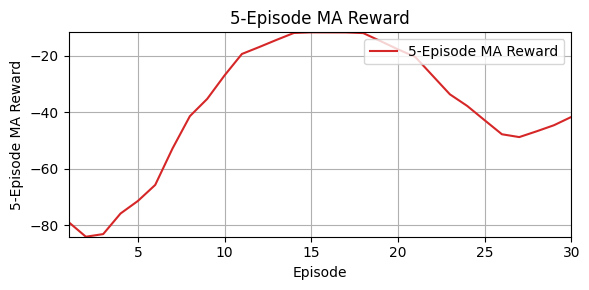

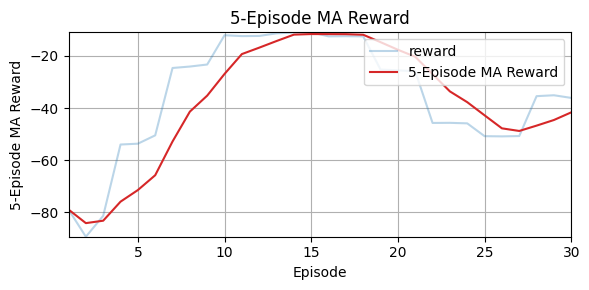

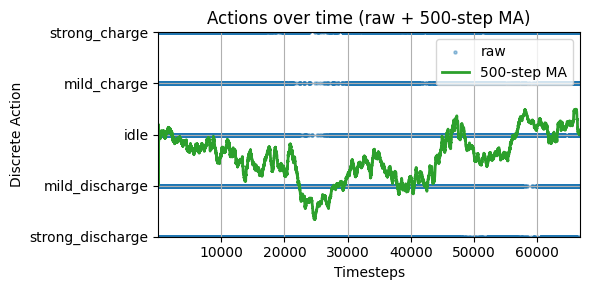

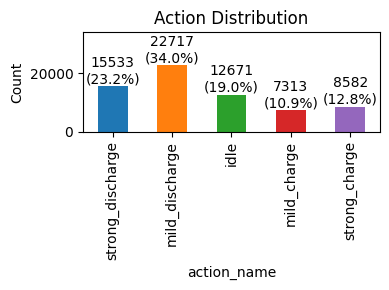

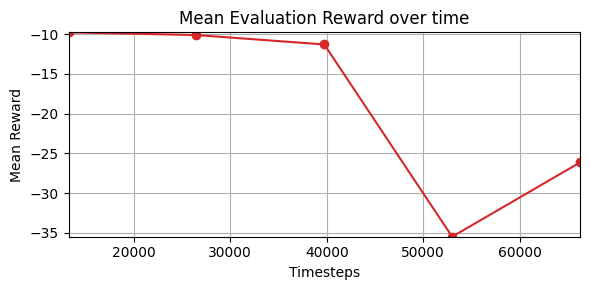

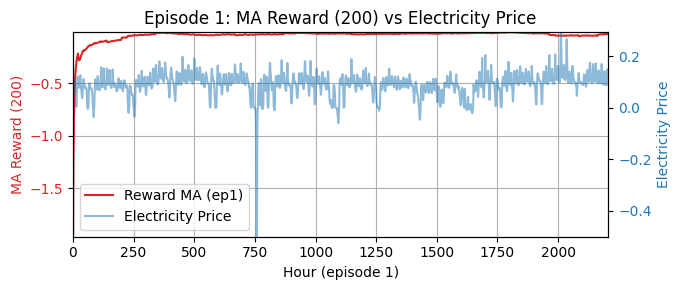

In [134]:
# ----- Plot 1: MA Training reward over Time -----

n_episodes = len(train_callback.ep_df)
print(f"Total episodes: {n_episodes}")

window = 5
smooth = train_callback.ep_df["return"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(6, 3))
plt.plot(train_callback.ep_df["episode_global"], smooth, color="C3", label=f"{window}-Episode MA Reward")
plt.title(f"{window}-Episode MA Reward")
plt.xlabel("Episode")
plt.ylabel(f"{window}-Episode MA Reward")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

"""
# Training loss (if available)
if hasattr(train_callback, "losses") and len(train_callback.losses) > 0:
    plt.figure(figsize=(6, 3))
    plt.plot(train_callback.loss_timesteps,
             train_callback.losses,
             marker='.', linestyle='-',
             alpha=0.7, color="C1")
    plt.title("Train Loss over time")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""


# ----- Plot 2: MA vs. Raw Training reward over Time -----
window = 5
smooth = train_callback.ep_df["return"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(6, 3))
plt.plot(train_callback.ep_df["episode_global"], train_callback.ep_df["return"], alpha=0.3, label='reward')
plt.plot(train_callback.ep_df["episode_global"], smooth, color="C3", label=f"{window}-Episode MA Reward")
plt.title(f"{window}-Episode MA Reward")
plt.xlabel("Episode")
plt.ylabel(f"{window}-Episode MA Reward")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# ----- Plot 3: Actions over Time-----
train_df = train_callback.df 

# Action → numerical representation
action_to_frac_5 = { 
    4: 1.0, 
    3: 0.5, 
    2: 0.0, 
    1: -0.5, 
    0: -1.0 }
train_df['action'] = train_df['action'].map(action_to_frac_5)
window = 500
train_df["action_ma"] = train_df["action_frac"].rolling(window, min_periods=1).mean()

# Raw actions
plt.figure(figsize=(6, 3))
plt.scatter(train_df["global_step"], train_df["action_frac"], s=5, alpha=0.4, label="raw")

# Moving average
plt.plot(
    train_df["global_step"],
    train_df["action_ma"],
    color="C2", lw=2,
    label=f"{window}-step MA"
)

plt.title(f"Actions over time (raw + {window}-step MA)")
plt.xlabel("Timesteps")
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], 
           ACTION_LABELS)
plt.ylabel('Discrete Action'); plt.legend(loc="upper right"); plt.grid(True); plt.tight_layout(); plt.show()


# ----- Plot 4: Action Distribution -----
plt.figure(figsize=(4,3))
counts = train_df['action_name'].value_counts().reindex(ACTION_LABELS).fillna(0)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


# ----- Plot 5: Evaluation Reward -----
all_eval = eval_callback.evaluations_results        # list of lists
steps    = eval_callback.evaluations_timesteps      # list of ints

# Compute per‐evaluation mean/std
mean_eval = [float(np.mean(r)) for r in all_eval]
std_eval  = [float(np.std(r))  for r in all_eval]

plt.figure(figsize=(6, 3))
plt.errorbar(
    steps, mean_eval,
    yerr=std_eval,
    fmt='-o', capsize=3, color="C3",
    label="Eval mean ±1σ"
)
plt.title("Mean Evaluation Reward over time")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
step_df = train_callback.df.copy()
# Keep first episode of env 0
ep0 = step_df[step_df['env_id']==0].groupby('episode').get_group(1).reset_index(drop=True)
# Rolling reward
window = 200
ep0['reward_ma'] = ep0['reward'].rolling(window, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(7,3))
ax1.plot(ep0.index, ep0['reward_ma'], color='C3', label='Reward MA (ep1)')
ax1.set_ylabel(f'MA Reward ({window})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Hour (episode 1)')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(prc.index[:len(ep0)], prc['electricity_pricing'][:len(ep0)], color='C0', alpha=0.5, label='Electricity Price')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')

lines = ax1.get_lines()+ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left')
plt.title(f'Episode 1: MA Reward ({window}) vs Electricity Price')
plt.tight_layout(); plt.show()

In [ ]:
# --- Month Tick Relabel Helpers (copyable) ---
# Option 1: Replace the formatter so it directly returns full month names.
# Call AFTER creating ax1 (and before final plt.show or after, then redraw).

def set_full_month_formatter(ax, episode_hours=2208):
    import matplotlib.ticker as mticker
    month_names = ["June", "July", "August"]
    seg = episode_hours // 3  # hours per month segment in your data layout
    def hours_to_full_month(x, pos):
        idx = (int(x) // seg) % 3
        return month_names[idx]
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(hours_to_full_month))


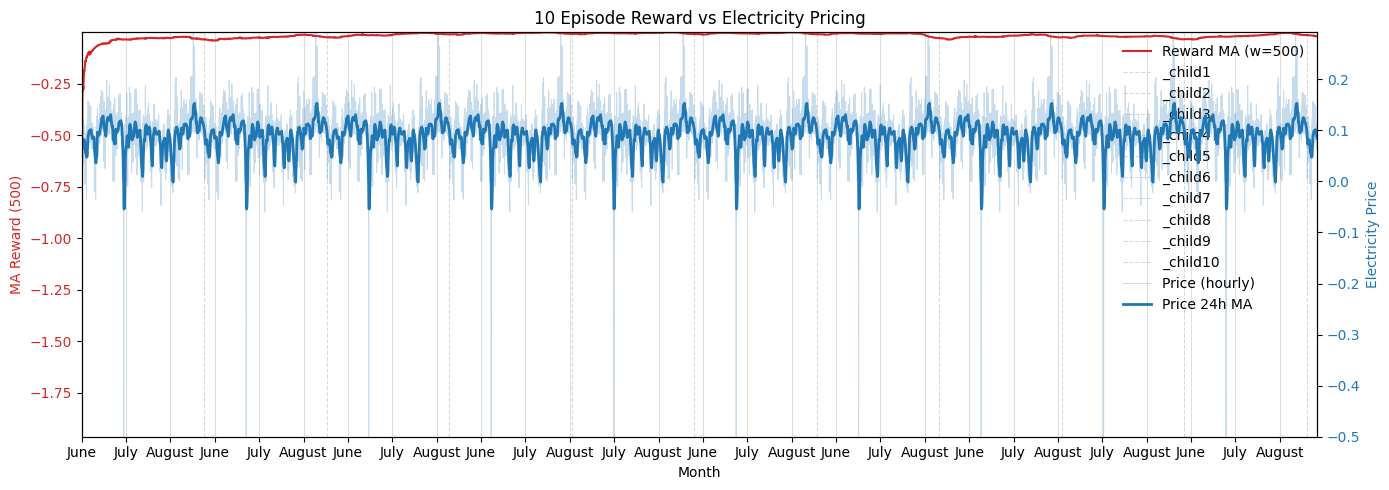

In [130]:
# Full-horizon Reward (env 0) vs Electricity Pricing (tiled across episodes)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Tunable parameters
window_reward = 500        # rolling window (hours) for reward smoothing
window_price_ma = 24       # rolling window (hours) for price smoothing
plot_hourly_price = True   # set False to hide raw noisy price
mark_episode_boundaries = True

# Episode length (hours) assumed constant
T = len(prc)   # == 2208

# Filter env 0 logs and order
df0 = train_callback.df[train_callback.df['env_id'] == 0].copy()
df0 = df0.sort_values(['episode', 'step_in_ep'])

# Continuous hour index across episodes
df0['hour_index'] = (df0['episode'] - 1) * T + df0['step_in_ep']

# Rolling reward smoothing
df0['reward_ma'] = df0['reward'].rolling(window_reward, min_periods=1).mean()

# Total hours recorded
n_hours_total = int(df0['hour_index'].max() + 1)

# Tile pricing to cover the whole training horizon (episodes replay same period)
n_repeats = int(np.ceil(n_hours_total / T))
price_tiled = np.tile(prc['electricity_pricing'].values, n_repeats)[:n_hours_total]
price_series = pd.Series(price_tiled)

# Smooth price
price_ma = price_series.rolling(window_price_ma, min_periods=1).mean()

# Align to df0 length (in case of partial last hour)
price_aligned = price_series.iloc[:len(df0)].values
price_ma_aligned = price_ma.iloc[:len(df0)].values

# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df0['hour_index'], df0['reward_ma'],
         color='C3', label=f'Reward MA (w={window_reward})')
# (Optional) Convert x-axis to day labels instead of hours:
def hours_to_month(x, pos): return f'M{(int(x)//(2208//3))%3 + 1}'

ax1.xaxis.set_major_locator(mticker.MaxNLocator(29))
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(hours_to_month))
set_full_month_formatter(ax1)

ax1.set_xlabel('Month')
ax1.set_ylabel(f'MA Reward ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.4)


fig.canvas.draw_idle()

ax2 = ax1.twinx()
if plot_hourly_price:
    ax2.plot(df0['hour_index'], price_aligned,
             color='C0', alpha=0.25, linewidth=0.7, label='Price (hourly)')
ax2.plot(df0['hour_index'], price_ma_aligned,
         color='C0', linewidth=2, label=f'Price {window_price_ma}h MA')
ax2.set_ylabel('Electricity Price', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

# Episode boundary markers
if mark_episode_boundaries:
    last_episode = int(df0['episode'].max())
    for ep in range(2, last_episode + 1):
        x = (ep - 1) * T
        ax1.axvline(x, color='k', linestyle='--', alpha=0.15, linewidth=0.8)

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=False)

plt.title('10 Episode Reward vs Electricity Pricing')
plt.tight_layout()
plt.show()



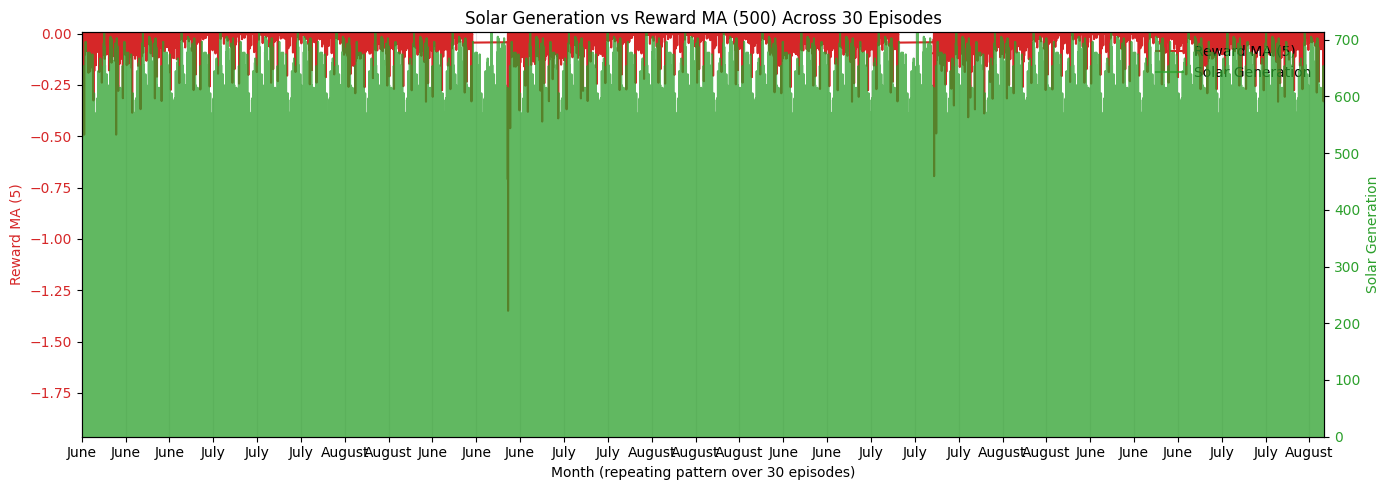

Episodes per env: 11, Env count: 3, Total synthetic global episodes: 33


In [ ]:
# Solar Generation vs Reward MA (500) Across 30 Global Episodes
# (Non-intrusive: derives global episodes without altering earlier code.)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Copy logged steps
df_all = train_callback.df.copy()

# Determine episodes per env (assumes uniform)
episodes_per_env = df_all.groupby('env_id')['episode'].max().min()
T = len(bld)  # episode length (hours)
num_envs = df_all['env_id'].nunique()
TotalEpisodes = num_envs * episodes_per_env  # expected 30

# Create a synthetic global episode index: env0 1..N, env1 N+1..2N, etc.
df_all['global_episode'] = df_all['env_id'] * episodes_per_env + df_all['episode']

# Global hour index across all 30 episodes
df_all['global_hour_index'] = (df_all['global_episode'] - 1) * T + df_all['step_in_ep']

# Sort by global hour to ensure monotonic order
df_all = df_all.sort_values('global_hour_index')

# Reward moving average (window 500 hours)
window_reward = 500
df_all['reward_ma500'] = df_all['reward'].rolling(window_reward, min_periods=1).mean()

# Tile solar generation across all global episodes (assumes each episode replays same base horizon)
solar_vals = np.tile(bld['solar_generation'].values, TotalEpisodes)
needed_len = int(df_all['global_hour_index'].max() + 1)
solar_vals = solar_vals[:needed_len]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df_all['global_hour_index'], df_all['reward_ma500'], color='C3', label=f'Reward MA ({window_reward})')
ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Global Hour (30 episodes)')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(range(needed_len), solar_vals, color='C2', alpha=0.75, label='Solar Generation')
ax2.set_ylabel('Solar Generation', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

# Optional: apply month formatter if helper is present (falls back silently if not)
try:
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(30))
    set_full_month_formatter(ax1)  # previously defined helper
    ax1.set_xlabel('Month (repeating pattern over 30 episodes)')
except Exception:
    pass

# Legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=False)

plt.title('Solar Generation vs Reward MA (500) Across 30 Episodes')
plt.tight_layout()
plt.show()

print(f"Episodes per env: {episodes_per_env}, Env count: {num_envs}, Total synthetic global episodes: {TotalEpisodes}")
